# Классификация для определения, будет ли зарплата не менее 50.000
### Набор данных взят [отсюда](https://www.kaggle.com/datasets/mastmustu/income)
Датасет изначально разделен на train (для тренировки) и test (проверки модели). Файлы называются соответственно.

В данном наборе изначально дано 15 столбцов и 41.000-44.000 строк с данными для каждой фичи

## Импорт библиотек
Начало работы знаменуется импортом библиотек, которые нам понадобятся.

Документации для них:

[pandas](https://pandas.pydata.org/docs/)

[numpy](https://numpy.org/doc/stable/)

[seaborn](https://seaborn.pydata.org/)

[matplotlib](https://matplotlib.org/stable/index.html)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
import warnings

warnings.simplefilter("ignore", UserWarning)

In [2]:
from datetime import datetime
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Затрачено времени: %i часов %i минут и %s секунд.' % (thour, tmin, round(tsec, 2)))

## Считываем данные из файла для тренировки модели

In [3]:
df = pd.read_csv("../data/train.csv")

# Предварительная обработка данных
## Проверка типов данных
Смотрим информацию о датасете, сколько записей содержится и какие типы данных у строк

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43957 entries, 0 to 43956
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              43957 non-null  int64 
 1   workclass        41459 non-null  object
 2   fnlwgt           43957 non-null  int64 
 3   education        43957 non-null  object
 4   educational-num  43957 non-null  int64 
 5   marital-status   43957 non-null  object
 6   occupation       41451 non-null  object
 7   relationship     43957 non-null  object
 8   race             43957 non-null  object
 9   gender           43957 non-null  object
 10  capital-gain     43957 non-null  int64 
 11  capital-loss     43957 non-null  int64 
 12  hours-per-week   43957 non-null  int64 
 13  native-country   43194 non-null  object
 14  income_>50K      43957 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.0+ MB


## Убираем строки с теми данными, которые не заполнены
Сначала посмотрим, сколько таких строк у нас всего

In [5]:
df.isnull().sum()

age                   0
workclass          2498
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2506
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      763
income_>50K           0
dtype: int64

Можно заметить, что число таких строк не большое относительно всего набора данных
На примере workclass: 2498 на 41459 всех записей. Поэтому такими строками можно пренебречь, убрав их.

Axis=0 уберет все строки (1 отвечает за столбцы), а inplace=True позволяет не порождать новый датафрейм, а изменять текущий

In [6]:
df.dropna(subset=["workclass", "occupation", "native-country"], axis=0, inplace=True)
df.isnull().sum() # После удаления пустых

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income_>50K        0
dtype: int64

## Дублирование строк
Не стоит забывать и о дублях некоторых записей, их тоже надо бы убрать

In [7]:
df[df.duplicated()].shape # Сколько таких строк
df.drop_duplicates(inplace=True)
df.count() # Сколько строк данных осталось

age                40686
workclass          40686
fnlwgt             40686
education          40686
educational-num    40686
marital-status     40686
occupation         40686
relationship       40686
race               40686
gender             40686
capital-gain       40686
capital-loss       40686
hours-per-week     40686
native-country     40686
income_>50K        40686
dtype: int64

## Работа с нерелевантными столбцами
### Необходимо понять, какие столбцы не будут актуальны для нас в будущем, поэтому следует рассмотреть их поближе
### Начнем с типа работы

<AxesSubplot: xlabel='count', ylabel='workclass'>

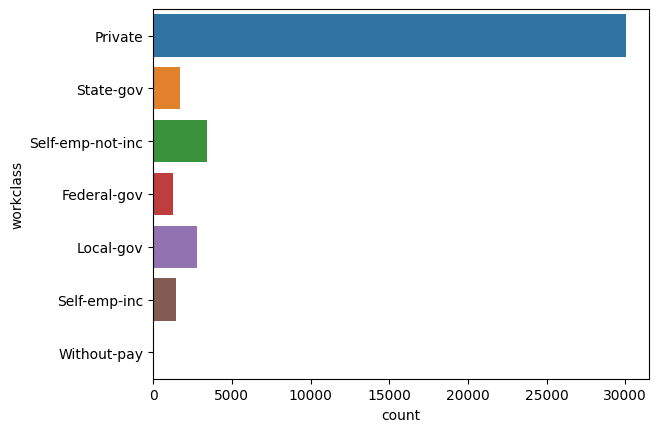

In [8]:
sns.countplot(y=df["workclass"])

In [9]:
without_pay = [row for row in df["workclass"] if row == "Without-pay"]
print(len(without_pay))

20


Категория Without-pay нас оприори не интересует, а количество таких записей вовсе мало - 20. Поэтому убираем эти данные из выборки

In [10]:
df.drop(df.index[df['workclass'] == 'Without-pay'], inplace=True)
df.shape # Смотрим, что осталось на самом деле на 20 строк меньше

(40666, 15)

### Образование
В данной выборке у нас есть 2 столбца, которые отвечают за образование:

Один имеет текстовый формат, другой - числовой. Уберем текстовый, оставим только число

In [11]:
df.drop(["education"], axis=1, inplace=True) # Исключение столбца с текстовым форматом

### Семейное положение
В данной выборке также имеется 2 различных столбца для семейного положения и отношений по отдельности.

Так как один из столбцов является аналогией другого, то один из них отбросим, а со вторым будет вестись работа.

Было выбрано убрать столбец "relationship" (отношения), оставить "marital-status" (семейное положение)

<AxesSubplot: xlabel='count', ylabel='marital-status'>

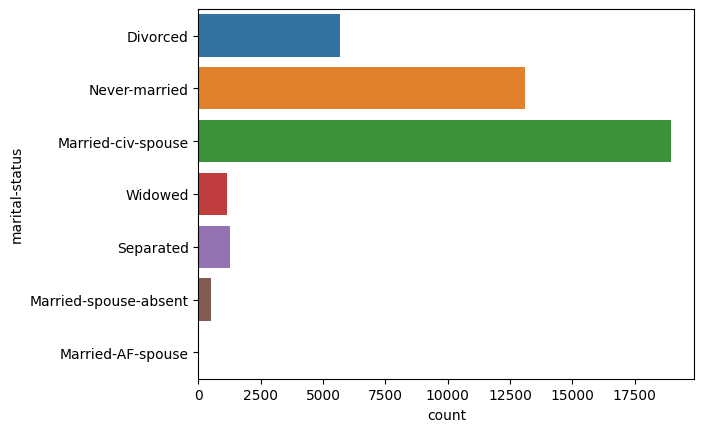

In [12]:
sns.countplot(y=df["marital-status"])

Separation means that you are living apart from your spouse but are still legally married until you get a judgment of divorce.

Все, что включает в себя слово married, кроме never-married, объединим в общую категорию "married". Separated, по описанию выше, тоже сюда входит.

Остальное - в категорию "single"

In [13]:
df["marital-status"].replace(
    ["Married-civ-spouse", "Separated", "Married-spouse-absent", "Married-AF-spouse"], 
    "married", 
    inplace=True)  # Заменяем на "married"

df["marital-status"].replace(
    ["Divorced", "Never-married", "Widowed"], 
    "single", 
    inplace=True) # Заменяем на "single"

Посмотрим на то, что вышло по итогу: сколько людей состоят в браке, а сколько - одиноки

<AxesSubplot: xlabel='count', ylabel='marital-status'>

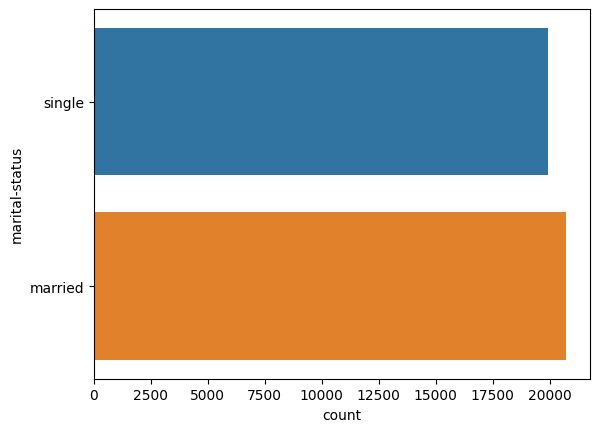

In [14]:
sns.countplot(y=df["marital-status"])

Обозначим этот столбец бинарно: 0 - одинок (-а), 1 - не одинок (-а). Это будет потом :)

Также вспомним, что у нас есть такой столбец как relationship, который теряет актуальность из-за разбиение на "одинок" и "в браке" в данном пункте, поэтому удаляем данный столбец

In [15]:
df.drop(columns='relationship', axis=1, inplace=True)

### Родная страна
Посмотрим, какие страны участвуют в выборке

<AxesSubplot: xlabel='count', ylabel='native-country'>

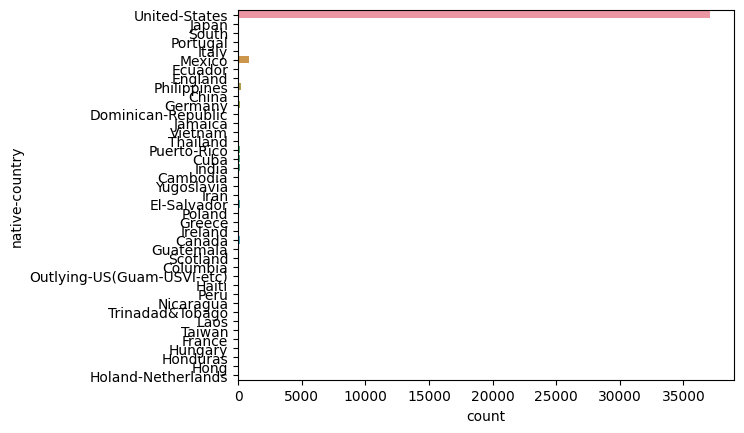

In [16]:
sns.countplot(y=df["native-country"])

Основная составляющая выборки - США. По этому можно отбросить эту фичу сразу, т.к. вклад она вносить как таковой не будет

In [17]:
df.drop(columns='native-country', axis=1, inplace=True)

# Визуализация оставшихся категориальных признаков

<AxesSubplot: xlabel='count', ylabel='race'>

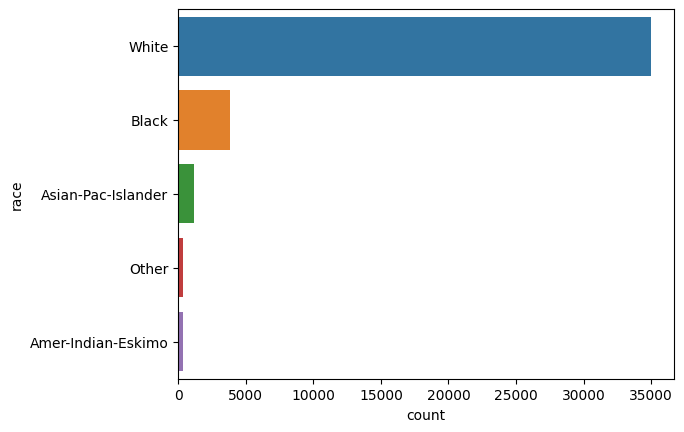

In [18]:
sns.countplot(y=df["race"])

<AxesSubplot: xlabel='count', ylabel='occupation'>

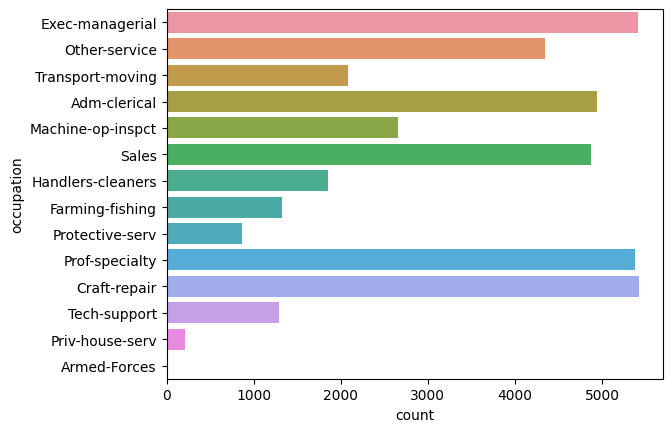

In [19]:
sns.countplot(y=df["occupation"]) # Род деятельности

## Замена категориальных признаков на числовые
Заменим категории "место работы", "род деятельности", "расу", "пол" и "семейное положение" на числовые значения.

In [20]:
print("До замены:")
print(df.info())
freq = df["workclass"].value_counts()
i = 0
for key in freq.keys():
    df.replace(key, i, inplace=True)
    i = i + 1
    
i = 0
freq = df["occupation"].value_counts()
for key in freq.keys():
    df.replace(key, i, inplace=True)
    i = i+1
    
i = 0
freq = df["race"].value_counts()
for key in freq.keys():
    df.replace(key, i, inplace=True)
    i = i+1
    
i = 0
freq = df["gender"].value_counts()
for key in freq.keys():
    df.replace(key, i, inplace=True)
    i = i+1
    
i = 0
freq = df["marital-status"].value_counts()
for key in freq.keys():
    df.replace(key, i, inplace=True)
    i = i+1
    
print("\nПосле замены:")
print(df.info())

До замены:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40666 entries, 0 to 43956
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              40666 non-null  int64 
 1   workclass        40666 non-null  object
 2   fnlwgt           40666 non-null  int64 
 3   educational-num  40666 non-null  int64 
 4   marital-status   40666 non-null  object
 5   occupation       40666 non-null  object
 6   race             40666 non-null  object
 7   gender           40666 non-null  object
 8   capital-gain     40666 non-null  int64 
 9   capital-loss     40666 non-null  int64 
 10  hours-per-week   40666 non-null  int64 
 11  income_>50K      40666 non-null  int64 
dtypes: int64(7), object(5)
memory usage: 4.0+ MB
None

После замены:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40666 entries, 0 to 43956
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype
---  ------           -----

In [21]:
df.drop(columns='fnlwgt', axis=1, inplace=True) #Повышает точность

# Проверка на сбалансированность данных

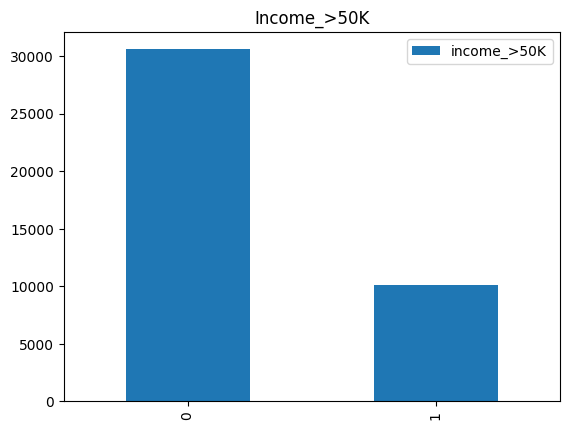

In [22]:
X = df.copy()
y = X.pop("income_>50K")

y.value_counts().plot(kind='bar', label='income_>50K')
plt.legend()
plt.title('Income_>50K');

Можно заметить, что у нас очень большой перевес в сторону того, что доход будет меньше 50.000. Если ничего не делать и оставить как есть, то в будущем модель будет плохо предсказывать класс 1.

Таким образом нам надо бы выровнять данные... Воспользуемся SMOTE. По итогу будет осуществлен процесс генерации синтетических данных, который придет выборку к сбалансированному виду на основе класса меньшинства.

In [23]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=10)
X, y = sm.fit_resample(X, y)
X_init, y_init = X, y    #оставим оригиналы

Посмотрим, что получилось теперь

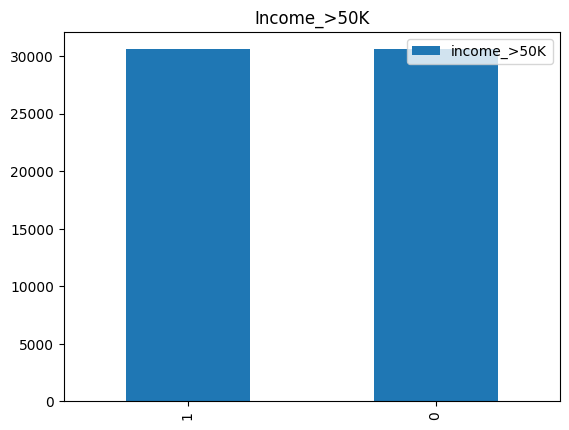

In [24]:
y.value_counts().plot(kind='bar', label='income_>50K')
plt.legend()
plt.title('Income_>50K');

Теперь данные сбалансированны, поэтому можем приступить к обучению моделей

# Если захочется проверить результат с удалением fnlwgt после SMOTE

In [25]:
#df.drop(columns='fnlwgt', axis=1, inplace=True)

## Тепловая карта
Тепловые карты - это тип графика, который необходим для поиска зависимых переменных. Один из лучших способов найти взаимосвязь между характеристиками: тепловые карты. 

,age,workclass,educational-num,marital-status,occupation,race,gender,capital-gain,capital-loss,hours-per-week,income_>50K
age,1.000000,0.166245,0.040624,-0.311793,-0.072004,-0.033375,-0.083774,0.078802,0.059374,0.101697,0.237614
workclass,0.166245,1.000000,0.173215,-0.092461,-0.052360,0.017842,-0.042329,0.055633,0.033317,0.080378,0.143604
educational-num,0.040624,0.173215,1.000000,-0.050131,-0.235972,-0.040176,-0.002306,0.128965,0.081023,0.148770,0.334596
marital-status,-0.311793,-0.092461,-0.050131,1.000000,0.077347,0.040875,0.391672,-0.073232,-0.068956,-0.218169,-0.410980
occupation,-0.072004,-0.052360,-0.235972,0.077347,1.000000,0.040446,0.008658,-0.057539,-0.037932,-0.065832,-0.165071
race,-0.033375,0.017842,-0.040176,0.040875,0.040446,1.000000,0.065967,-0.009190,-0.019450,-0.034901,-0.064168
gender,-0.083774,-0.042329,-0.002306,0.391672,0.008658,0.065967,1.000000,-0.046239,-0.044283,-0.231141,-0.215815
capital-gain,0.078802,0.055633,0.128965,-0.073232,-0.057539,-0.009190,-0.046239,1.000000,-0.032177,0.084666,0.221726
capital-loss,0.059374,0.033317,0.081023,-0.068956,-0.037932,-0.019450,-0.044283,-0.032177,1.000000,0.054923,0.145323
hours-per-week,0.101697,0.080378,0.148770,-0.218169,-0.065832,-0.034901,-0.231141,0.084666,0.054923,1.000000,0.227749


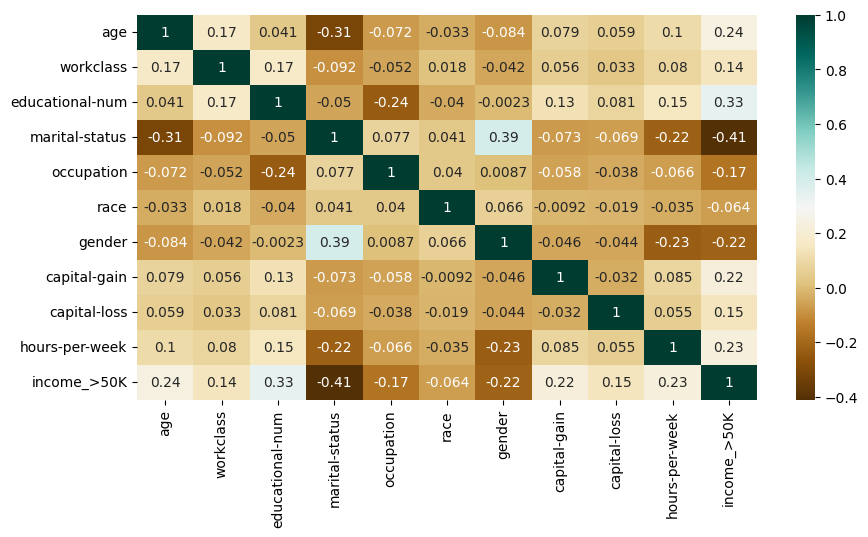

In [26]:
plt.figure(figsize=(10,5))
c = df.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c

С чем работаем:

In [27]:
pd.DataFrame(X)

,age,workclass,educational-num,marital-status,occupation,race,gender,capital-gain,capital-loss,hours-per-week
0,67,0,16,1,1,0,0,99999,0,60
1,17,0,8,1,5,0,0,0,0,15
2,31,0,13,0,1,0,0,0,0,40
3,58,3,4,0,7,0,0,0,0,40
4,25,3,10,1,5,1,0,0,0,40
...,...,...,...,...,...,...,...,...,...,...
61157,32,0,12,0,1,0,0,0,0,60
61158,29,0,9,0,2,0,0,0,0,40
61159,44,0,13,0,4,0,0,0,0,44
61160,29,0,13,0,10,0,0,0,0,40


# Построение моделей
## PCA
[Документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

[Как пользоваться](https://pythobyte.com/implementing-pca-in-python-with-scikit-learn-969a7354/)

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

sc = StandardScaler()  #PCA работает с нормализованными данными!
X_sc = sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_sc, y, test_size=0.3, stratify=y, random_state = 100)

#X_train_sc = sc.fit_transform(X_train)
#X_test_sc = sc.transform(X_test)
#y_train_sc = sc.fit_transform(y_train)
#y_test_sc = sc.transform(y_test)

Воспользуемся деревом решений, где еще не использовали PCA, посмотрим точность

In [29]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state = 100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
cf_matrix = confusion_matrix(y_pred, y_test)
print(cf_matrix)

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      9175
           1       0.83      0.87      0.85      9174

    accuracy                           0.84     18349
   macro avg       0.85      0.84      0.84     18349
weighted avg       0.85      0.84      0.84     18349

[[7545 1215]
 [1630 7959]]


А теперь подключим PCA

In [30]:
from sklearn.decomposition import PCA

pca = PCA()
X_sc_centered = X_sc - X_sc.mean(axis=0)
pca.fit(X_sc_centered)
X_pca = pca.transform(X_sc_centered)

explained_variance = pca.explained_variance_ratio_
for i, ratio in enumerate(explained_variance):
    print(f"{i}: {round(ratio*100, 2)} %")

0: 20.42 %
1: 12.06 %
2: 10.61 %
3: 10.35 %
4: 9.63 %
5: 9.02 %
6: 8.73 %
7: 7.37 %
8: 6.74 %
9: 5.06 %


Посмотрим, какие результаты, если ничего не трогать

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.3, stratify=y, random_state = 100)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
cf_matrix = confusion_matrix(y_pred, y_test)
print(cf_matrix)

              precision    recall  f1-score   support

           0       0.83      0.80      0.82      9175
           1       0.81      0.84      0.82      9174

    accuracy                           0.82     18349
   macro avg       0.82      0.82      0.82     18349
weighted avg       0.82      0.82      0.82     18349

[[7348 1464]
 [1827 7710]]


Результат нееемноого ухудшился, но не критично.

Теперь возьмем первые 2 компонента, т.к. они вносят наибольший вклад. Ну и на основе их сделаем визуализацию

In [32]:
pca = PCA(n_components=2)
X_sc_centered = X_sc - X_sc.mean(axis=0)
pca.fit(X_sc_centered)
X_pca = pca.transform(X_sc_centered)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state = 100)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
cf_matrix = confusion_matrix(y_pred, y_test)
print(cf_matrix)

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      9175
           1       0.83      0.87      0.85      9174

    accuracy                           0.85     18349
   macro avg       0.85      0.85      0.85     18349
weighted avg       0.85      0.85      0.85     18349

[[7550 1217]
 [1625 7957]]


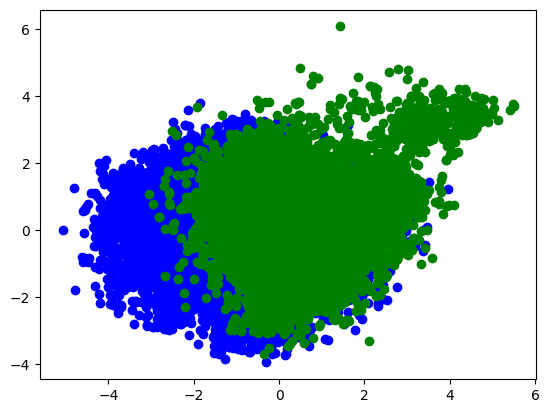

In [33]:
plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], "bo")
plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], "go")

## Попробуем дерево без нормализации данных

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X_init, y_init, test_size=0.3, stratify=y, random_state = 100)

clf = DecisionTreeClassifier(random_state = 100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
cf_matrix = confusion_matrix(y_pred, y_test)
print(cf_matrix)

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      9175
           1       0.83      0.87      0.85      9174

    accuracy                           0.85     18349
   macro avg       0.85      0.85      0.85     18349
weighted avg       0.85      0.85      0.85     18349

[[7550 1217]
 [1625 7957]]


### Посмотрим разницу
![PCA](./imgs/2/pca_v2.png)

Не настраивая PCA никак, мы теряем 2% точности в общем случае. А вот уже выбирая n_components 1 и выше мы будем получать те же значения, близкие к дереву решений. Хоть и значения точности пишутся разные (0.84 и 0.85), на самом деле там разница крайне мала.

Но это в случае, если дереву решений подавать стандартизованные данные. На изначальном наборе точность предсказаний у DT и DT после PCA одинаковая.

## KMeans
[Документация](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

[habr](https://habr.com/ru/post/67078/)

Text(0.5, 1.0, 'PCA')

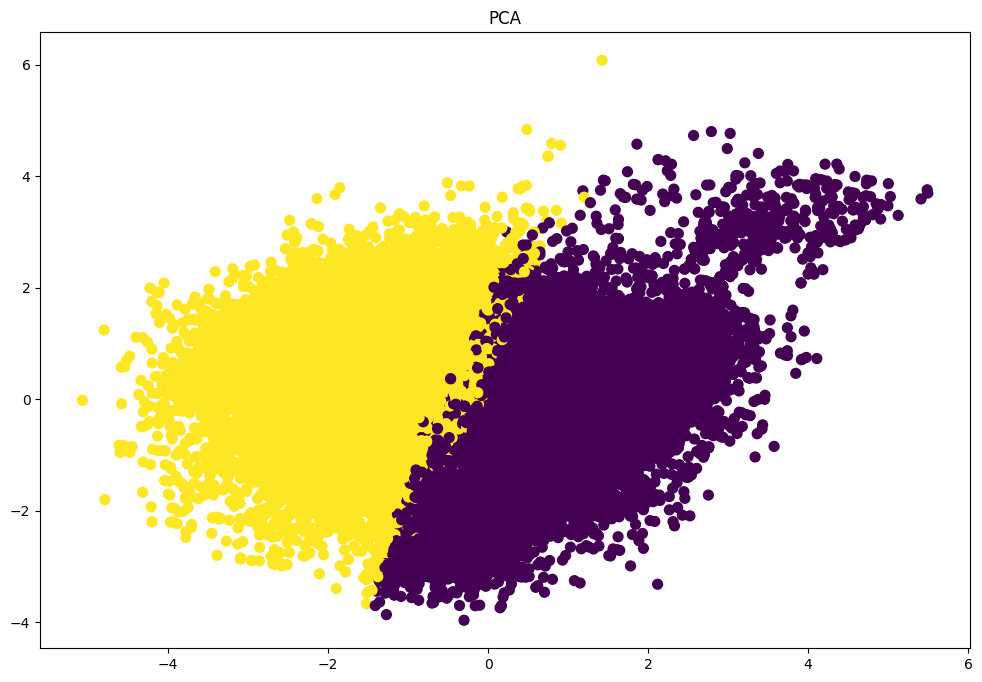

In [35]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=100)
kmeans.fit(X_sc)

# Visualizing using PCA
pca = PCA(n_components=2)
res = pca.fit_transform(X_sc)
plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=kmeans.labels_, s=50, cmap='viridis')
plt.title('PCA')

In [36]:
#Слегка уменьшим, а то будет такая ошибка:
#Unable to allocate 27.9 GiB for an array with shape (61162, 61162) and data type float64
from itertools import combinations_with_replacement

NUM_OF_DATA = 61162

labels = pd.DataFrame(kmeans.labels_[:NUM_OF_DATA])
labels = labels.rename(columns = {0: 'Assessment_Results'})
combinations = [[1, 0], [0, 1]]
y_compare = pd.DataFrame(y[:NUM_OF_DATA]).rename(columns={"income_>50K": "Assessment_Results"})

for i in combinations:
    num_replace = {'Assessment_Results': {0: i[0], 1: i[1]}}
    res = (labels.replace(num_replace) - y_compare).value_counts()
    print(res)
    print(round(100*res[0]/NUM_OF_DATA, 2), "%")

Assessment_Results
 0                    47363
 1                    10909
-1                     2890
dtype: int64
77.44 %
Assessment_Results
-1                    27691
 1                    19672
 0                    13799
dtype: int64
22.56 %


Как видим по результатам, было правильно определено 77,44% значений

## DBSCAN
[habr](https://habr.com/ru/post/322034/)

[Документация](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

Text(0.5, 1.0, 'PCA')

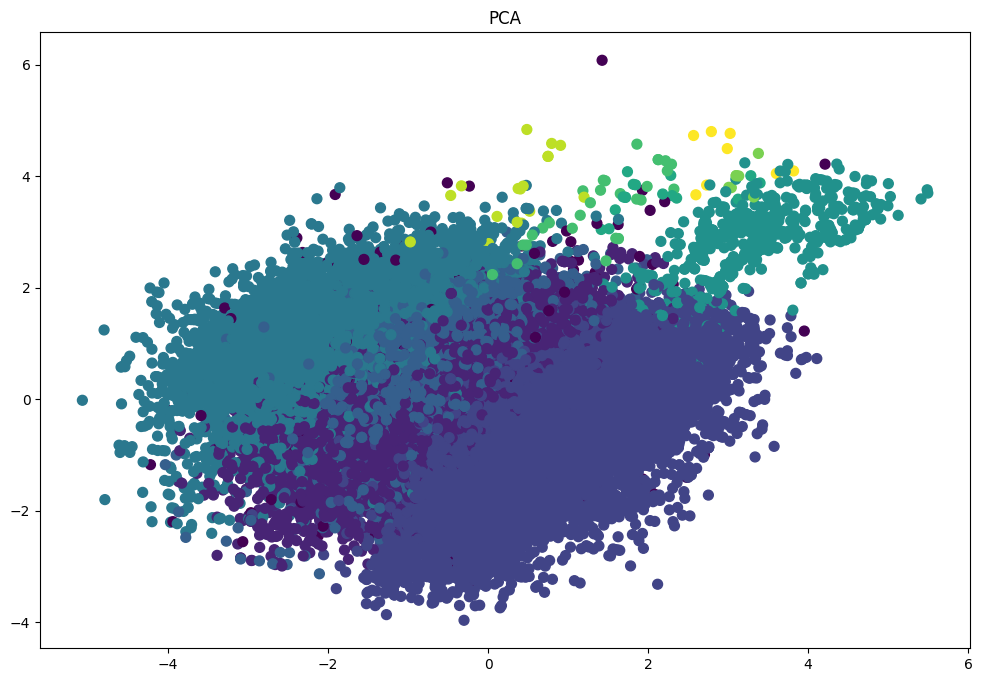

In [37]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=2.0, min_samples=5).fit(X_sc)

# Visualizing using PCA
pca = PCA(n_components=2)
res = pca.fit_transform(X_sc)
plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=dbscan.labels_, s=50, cmap='viridis')
plt.title('PCA')

In [38]:
pd.DataFrame(dbscan.labels_).value_counts()

 1    35414
 0    10704
 3    10373
 2     3787
 4      583
-1      222
 6       31
 8       17
 5       16
 9        8
 7        7
dtype: int64

In [39]:
labels = pd.DataFrame(dbscan.labels_[:NUM_OF_DATA])
labels = labels.rename(columns = {0: 'Assessment_Results'})
combinations = [[1, 0], [0, 1]]

for i in combinations:
    num_replace = {'Assessment_Results': {0: i[0], 1: i[1]}}
    res = (labels.replace(num_replace) - y_compare).value_counts()
    print(res)
    print(round(100*res[0]/NUM_OF_DATA, 2), "%")

Assessment_Results
-1                    25662
 0                    11749
 1                    10647
 3                    10214
 2                     2750
-2                       61
 5                       31
 7                       17
 4                       16
 8                        8
 6                        7
dtype: int64
19.21 %
Assessment_Results
 0                    34369
 1                    11692
 3                    10214
 2                     2750
-1                     1997
-2                       61
 5                       31
 7                       17
 4                       16
 8                        8
 6                        7
dtype: int64
56.19 %


Для эпсилон = 2 были применены разное кол-во соседей. Их количество и процент верных предсказаний ниже:
-  5: 56.19 %
- 10: 56.15 %
- 15: 56.12 %
- 20: 56.08 %

## Иерархическая кластеризация
[Документация](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)

Text(0.5, 1.0, 'PCA')

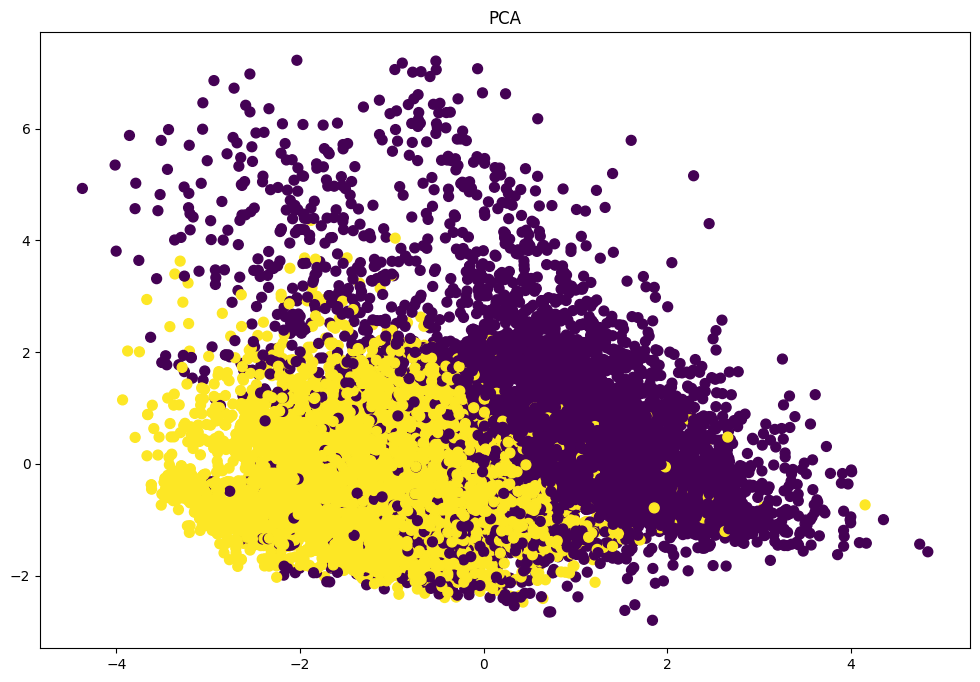

In [40]:
from sklearn.cluster import AgglomerativeClustering

NUM_OF_DATA_SMALL = 20000

X_sc_small = X_sc[:NUM_OF_DATA_SMALL]
y_compare_small = y_compare[:NUM_OF_DATA_SMALL]

agglomerative = AgglomerativeClustering(n_clusters = 2).fit(X_sc_small)

# Visualizing using PCA
pca = PCA(n_components=2)
res = pca.fit_transform(X_sc_small)
plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=agglomerative.labels_, s=50, cmap='viridis')
plt.title('PCA')

In [41]:
labels = pd.DataFrame(agglomerative.labels_[:NUM_OF_DATA_SMALL])
labels = labels.rename(columns = {0: 'Assessment_Results'})
combinations = [[1, 0], [0, 1]]

for i in combinations:
    num_replace = {'Assessment_Results': {0: i[0], 1: i[1]}}
    res = (labels.replace(num_replace) - y_compare_small).value_counts()
    print(res)
    print(round(100*res[0]/NUM_OF_DATA, 2), "%")

Assessment_Results
 0                    12691
 1                     6473
-1                      836
dtype: int64
20.75 %
Assessment_Results
 1                    8532
 0                    7309
-1                    4159
dtype: int64
11.95 %


20.75% ну совсем никуда не годится

Попробуем другую метрику

- ‘ward’ минимизирует дисперсию объединяемых кластеров.

- ‘average’ использует среднее значение расстояний каждого наблюдения двух наборов.

- ‘complete’ or ‘maximum’ использует максимальные расстояния между всеми наблюдениями двух наборов.

- ‘single’ использует минимум расстояний между всеми наблюдениями двух наборов.

Text(0.5, 1.0, 'PCA')

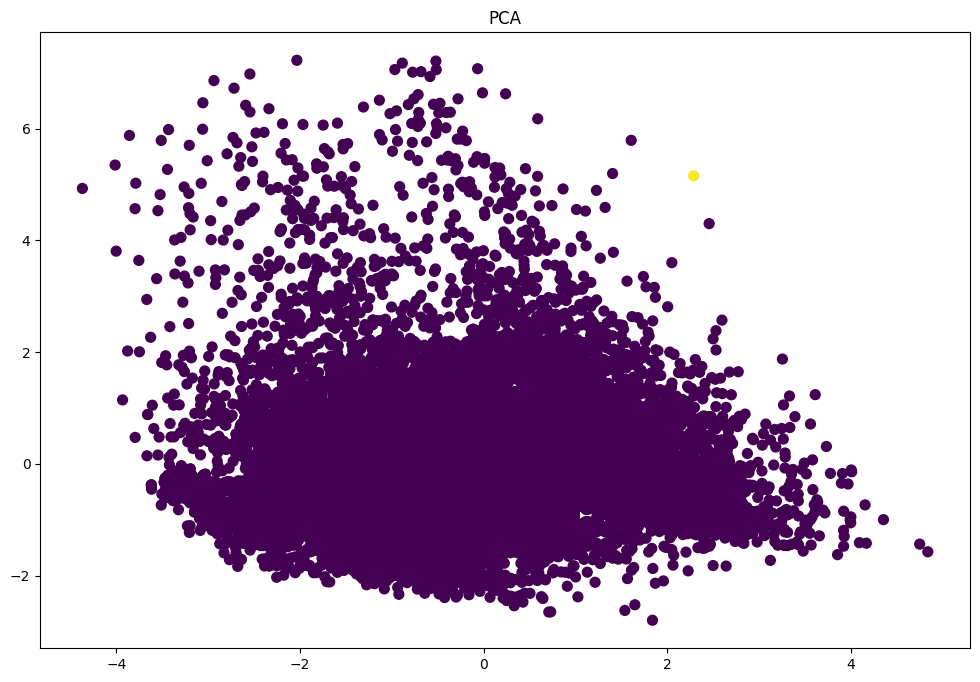

In [42]:
X_sc_small = X_sc[:NUM_OF_DATA_SMALL]
y_compare_small = y_compare[:NUM_OF_DATA_SMALL]

agglomerative = AgglomerativeClustering(n_clusters = 2, linkage="single", affinity="manhattan").fit(X_sc_small)

# Visualizing using PCA
pca = PCA(n_components=2)
res = pca.fit_transform(X_sc_small)
plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=agglomerative.labels_, s=50, cmap='viridis')
plt.title('PCA')

In [43]:
labels = pd.DataFrame(agglomerative.labels_[:NUM_OF_DATA_SMALL])
labels = labels.rename(columns = {0: 'Assessment_Results'})
combinations = [[1, 0], [0, 1]]

for i in combinations:
    num_replace = {'Assessment_Results': {0: i[0], 1: i[1]}}
    res = (labels.replace(num_replace) - y_compare_small).value_counts()
    print(res)
    print(round(100*res[0]/NUM_OF_DATA, 2), "%")

Assessment_Results
1                     15004
0                      4996
dtype: int64
8.17 %
Assessment_Results
 0                    15004
-1                     4995
 1                        1
dtype: int64
24.53 %


Так уже больше верных предсказаний, но все равно желает ждать лучшего

## Mean-shift
[документация](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html)


 Затрачено времени: 0 часов 24 минут и 41.78 секунд.


Text(0.5, 1.0, 'PCA')

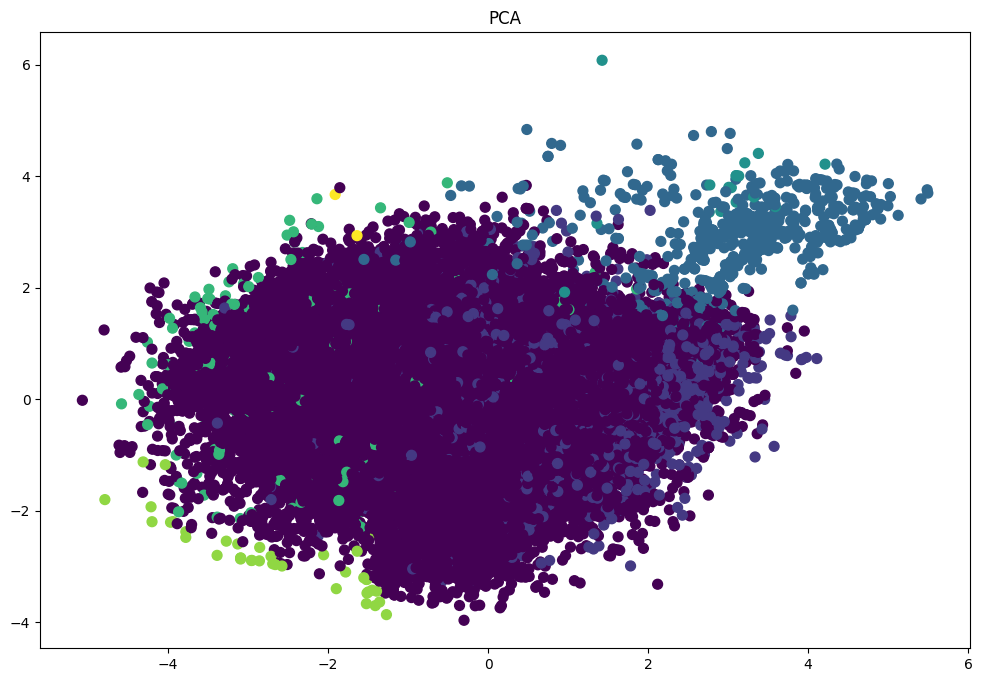

In [44]:
from sklearn.cluster import MeanShift

start = timer()
shift = MeanShift().fit(X_sc)
timer(start)

# Visualizing using PCA
pca = PCA(n_components=2)
res = pca.fit_transform(X_sc)
plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=shift.labels_, s=50, cmap='viridis')
plt.title('PCA')

In [45]:
labels = pd.DataFrame(shift.labels_)
labels = labels.rename(columns = {0: 'Assessment_Results'})
combinations = [[1, 0], [0, 1]]

for i in combinations:
    num_replace = {'Assessment_Results': {0: i[0], 1: i[1]}}
    res = (labels.replace(num_replace) - y_compare).value_counts()
    print(res)
    print(round(100*res[0]/NUM_OF_DATA, 2), "%")

Assessment_Results
 1                    30016
 0                    27814
-1                     2936
 4                      283
 3                       51
 5                       43
 2                       19
dtype: int64
45.48 %
Assessment_Results
 0                    32292
-1                    26911
 1                     1563
 4                      283
 3                       51
 5                       43
 2                       19
dtype: int64
52.8 %


## EM
[Документация](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture)

Text(0.5, 1.0, 'PCA')

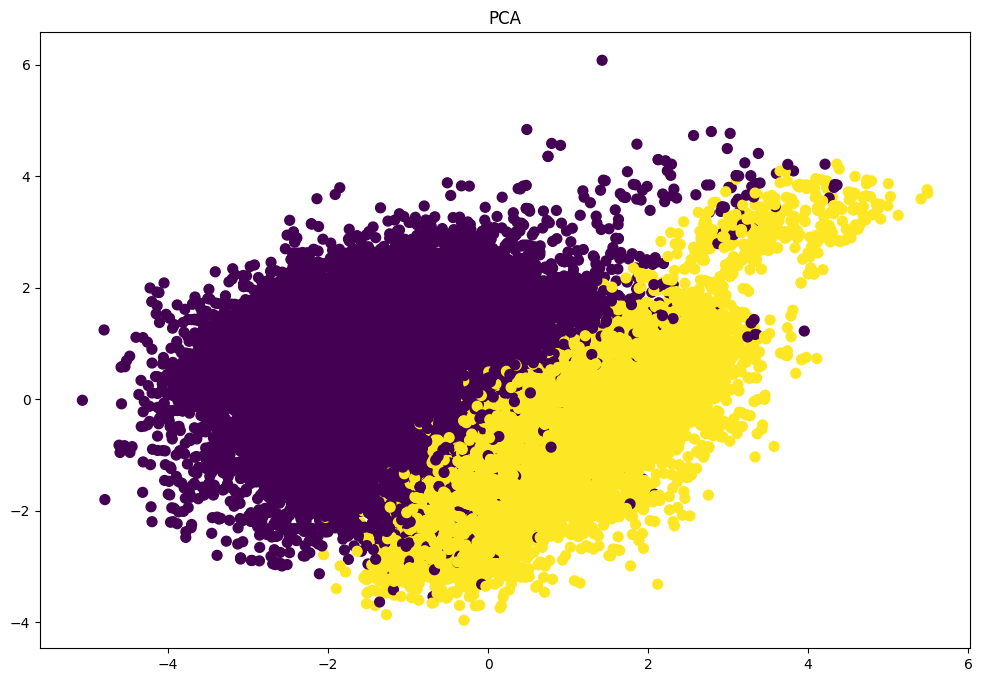

In [46]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=2, random_state=100).fit(X_sc)
labels = gm.predict(X_sc)
pd.DataFrame(labels).value_counts()

pca = PCA(n_components=2)
res = pca.fit_transform(X_sc)
plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=labels, s=50, cmap='viridis')
plt.title('PCA')

In [47]:
labels = pd.DataFrame(labels)
labels = labels.rename(columns = {0: 'Assessment_Results'})
combinations = [[1, 0], [0, 1]]

for i in combinations:
    num_replace = {'Assessment_Results': {0: i[0], 1: i[1]}}
    res = (labels.replace(num_replace) - y_compare).value_counts()
    print(res)
    print(round(100*res[0]/NUM_OF_DATA, 2), "%")

Assessment_Results
-1                    24731
 1                    21766
 0                    14665
dtype: int64
23.98 %
Assessment_Results
 0                    46497
 1                     8815
-1                     5850
dtype: int64
76.02 %


76% вполне приятный результат

# Итог
### Результаты верных предсказаний:
- DT с РСА:  85.0 %
- KMeans:    77.5 %
- DBScan:    56.0 %
- Иерарх.:   24.5 %
- MeanShift: 52.8 %
- EM:        76.0 %